In [78]:
#PCA METHOD WITH REPORTING
import pandas as pd
import numpy as np
import math
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def reduce_pca_by_variance(data: np.ndarray, feature_names: list, variance_threshold: float):
    """
    Performs PCA on n-dimensional data, automatically selecting the minimum
    number of components to explain at least the `variance_threshold`.
    
    This modified version also prints the results of the reduction and
    the top 5 feature contributors for each component.

    Args:
        data: A (n_samples, n_features) NumPy array.
        feature_names: A list of strings corresponding to the feature columns
                       in `data`. (e.g., list(df.columns))
        variance_threshold: The target amount of variance to explain
                            (e.g., 0.95 for 95%).

    Returns:
        A tuple containing:
        - data_transformed (np.ndarray): The data projected onto the
                                         new component space.
        - fitted_pca (PCA): The fitted PCA object, which you can use
                            to inspect the number of components, etc.
        - explained_variance_list (list): A list of the variance explained
                                          by each component (e.g., [0.5, 0.3]).
    """
    
    if len(feature_names) != data.shape[1]:
        raise ValueError(f"Number of feature_names ({len(feature_names)}) does not "
                         f"match number of data columns ({data.shape[1]}).")

    # 1. Create a PCA object with the variance threshold.
    # By setting n_components to a float, PCA automatically finds
    # the components needed to explain that much variance.
    pca = PCA(n_components=variance_threshold)
    
    # 2. Create a pipeline to first scale the data, then run PCA.
    # Scaling is crucial for PCA to work correctly.
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', pca)
    ])
    
    # 3. Fit the pipeline to the data and transform it
    data_transformed = pipeline.fit_transform(data)
    
    # --- Report print statements ---
    
    # Get the original and new dimensions
    original_dimensions = data.shape[1]
    # We access the fitted pca object from step 2
    new_dimensions = pca.n_components_ 
    
    print("-" * 30)
    print("PCA Dimensionality Reduction Report")
    print("-" * 30)
    print(f"Original dimensions:   {original_dimensions}")
    print(f"New dimensions:        {new_dimensions}")
    print(f"Dimensions reduced by: {original_dimensions - new_dimensions}")
    print("\nVariance explained by each remaining component:")
    
    # pca.explained_variance_ratio_ is an array like [0.5, 0.3, 0.1]
    for i, variance in enumerate(pca.explained_variance_ratio_):
        print(f"  Principal Component {i+1}: {variance * 100:.2f}%")
        
    # Print total variance explained
    total_variance = np.sum(pca.explained_variance_ratio_)
    print(f"\nTotal variance explained: {total_variance * 100:.2f}%")
    print(f"(Target threshold was {variance_threshold * 100:.0f}%)")
    
    # --- New: Top 5 Contributors per Component Report ---
    print("\nTop 5 Contributors per Component:")
    
    # pca.components_ has shape (n_components, n_features)
    for i, component in enumerate(pca.components_):
        print(f"  --- Principal Component {i+1} ---")
        
        # Get indices of the top 5 absolute loadings
        # np.argsort returns indices of smallest to largest
        # We take the last 5, and then reverse them [::-1]
        top_5_indices = np.argsort(np.abs(component))[-5:][::-1]
        
        # Print the feature name and its loading (weight)
        for j, feature_index in enumerate(top_5_indices):
            feature_name = feature_names[feature_index]
            loading = component[feature_index]
            print(f"    {j+1}. {feature_name}: {loading:.4f}")
            
    print("-" * 30)
    
    # --- End of report ---
    
    # Get the list of explained variances
    explained_variance_list = pca.explained_variance_ratio_.tolist()
    
    # Return the new data, the fitted PCA object, and the list of variances
    return data_transformed, pca, explained_variance_list


# Processing

In [23]:
# Get data to be a numpy array probably
df=pd.read_csv('consolidated_acs_data_clean.csv')
data=np.array(df)
income_index=1  # Example index for income dimension
# Transform the income dimension by logarithmic scale
data[:, income_index] = np.log(data[:, income_index].astype(np.float64))
# Normalize data by dividing by standard deviation by dimension
for i in range(1,data.shape[1]):
    data[:, i] = data[:, i] / np.std(data[:, i])


## Weighting

In [ ]:
# Initilize weights, and scale data by weights
# Get column indices
income_index = 1  # per_capita_income
poverty_index = df.columns.get_loc('avg_poverty_ratio')
employment_index = df.columns.get_loc('in_labor_force')
healthcare_index = df.columns.get_loc('Educational services, and health care and social assistance')
education_index = df.columns.get_loc('College or More')
commute_index = df.columns.get_loc('avg_commute_time')
housing_index = df.columns.get_loc('avg_housing_cost_burden')
race_indices = [df.columns.get_loc(col) for col in ['white', 'black', 'asian', 'native', 'pacific islander', 'other']]

# Apply dimension weights
data[:, income_index] *= 0.1225          # Economic Security - Income
data[:, poverty_index] *= 0.0525         # Economic Security - Poverty
data[:, employment_index] *= 0.07        # Economic Security - Employment
data[:, healthcare_index] *= 0.105       # Economic Security - Healthcare
data[:, education_index] *= 0.15         # Education
data[:, commute_index] *= 0.15           # Location Affordability - Transportation
data[:, housing_index] *= 0.15           # Location Affordability - Housing

# Race: distribute 0.2 across 6 race columns
for idx in race_indices:
    data[:, idx] *= 0.2 / 6  # 0.0333 per column

weights = np.array([
    0.1225,     # 1:  per_capita_income (Economic Security - Income)
    0.2/6,      # 2:  white (Cultural - Race)
    0.2/6,      # 3:  black (Cultural - Race)
    0.2/6,      # 4:  asian (Cultural - Race)
    0.2/6,      # 5:  native (Cultural - Race)
    0.2/6,      # 6:  pacific islander (Cultural - Race)
    0.2/6,      # 7:  other (Cultural - Race)
    0.0,        # 8:  Under High School (not weighted)
    0.0,        # 9:  High School (No College Degree) (not weighted)
    0.15,       # 10: College or More (Education)
    0.0,        # 11: Agriculture (not weighted)
    0.0,        # 12: Construction_and_manufacturing (not weighted)
    0.0,        # 13: trade (not weighted)
    0.0,        # 14: Transportation and warehousing (not weighted)
    0.0,        # 15: nerds (not weighted)
    0.105,      # 16: Educational services, and health care (Economic Security - Healthcare)
    0.0,        # 17: finance_inurance_and_realty (not weighted)
    0.0,        # 18: other_services (not weighted)
    0.07,       # 19: in_labor_force (Economic Security - Employment)
    0.0,        # 20: out_labor_force (not weighted)
    0.15,       # 21: avg_commute_time (Location Affordability - Transportation)
    0.15,       # 22: avg_housing_cost_burden (Location Affordability - Housing)
    0.0525,     # 23: avg_poverty_ratio (Economic Security - Poverty)
])


In [79]:
# Perform PCA, and project onto the top N dimensions so that they explain 50% of the variance
new_data,pca,var_explained = reduce_pca_by_variance(data[:,1:], list(df.columns)[1:], variance_threshold=0.5)

------------------------------
PCA Dimensionality Reduction Report
------------------------------
Original dimensions:   23
New dimensions:        6
Dimensions reduced by: 17

Variance explained by each remaining component:
  Principal Component 1: 16.07%
  Principal Component 2: 10.11%
  Principal Component 3: 8.43%
  Principal Component 4: 6.79%
  Principal Component 5: 6.32%
  Principal Component 6: 5.67%

Total variance explained: 53.38%
(Target threshold was 50%)

Top 5 Contributors per Component:
  --- Principal Component 1 ---
    1. College or More: 0.4448
    2. avg_poverty_ratio: 0.3872
    3. Under High School: -0.3443
    4. per_capita_income: 0.2592
    5. in_labor_force: 0.2370
  --- Principal Component 2 ---
    1. out_labor_force: 0.4101
    2. in_labor_force: -0.4101
    3. white: 0.3803
    4. pacific islander: 0.3752
    5. Agriculture, forestry, fishing and hunting, and mining: 0.2772
  --- Principal Component 3 ---
    1. High School (No College Degree): 0.4196
   

As shown, the first component has a distinct identity, namely education, income and poverty, part of the most important factors typically considered as determinant of a person's sociol-economic status. The rest of the components are a mixed of race, education, occupation, and comute time.

# Network initialization

Compile markers per dimension to show the resolution of the network.

Now we need to prune the markers and connect the nodes that connect to the same markers

## Geographic weighting

In [92]:
import pickle
from scipy.sparse import load_npz

# Create graph

# Load adjacency matrix
adj_matrix = load_npz('adjacency_queen_matrix.npz')

# Load mappings
with open('adjacency_queen_mappings.pkl', 'rb') as f:
    mappings = pickle.load(f)
index_to_geoid = mappings['index_to_geoid']

# Get edges from sparse matrix
rows, cols = adj_matrix.nonzero()

# Add edges with your weight
weight = 100  # Change this to your desired weight

for i, j in zip(rows, cols):
    if i < j:  # Only add each edge once (undirected)
        geoid1 = index_to_geoid[i]
        geoid2 = index_to_geoid[j]
        G.add_edge(i, j, weight=weight)


In [96]:
index_partitions

{0: [27,
  43,
  47,
  51,
  52,
  59,
  68,
  69,
  70,
  72,
  82,
  92,
  94,
  96,
  97,
  104,
  108,
  121,
  123,
  125,
  126,
  127,
  169,
  170,
  172,
  185,
  187,
  214,
  226,
  229,
  244,
  265,
  266,
  276,
  283,
  286,
  308,
  309,
  310,
  314,
  324,
  328,
  350,
  351,
  352,
  373,
  400,
  407,
  411,
  413,
  450,
  460,
  471,
  482,
  486,
  503,
  504,
  509,
  512,
  515,
  518,
  520,
  524,
  535,
  541,
  546,
  570,
  594,
  601,
  609,
  611,
  621,
  623,
  631,
  634,
  639,
  672,
  673,
  683,
  705,
  730,
  750,
  774,
  778,
  782,
  785,
  786,
  792,
  799,
  806,
  812,
  814,
  815,
  821,
  823,
  825,
  828,
  832,
  852,
  867,
  868,
  873,
  882,
  894,
  902,
  908,
  909,
  911,
  912,
  913,
  914,
  918,
  923,
  927,
  933,
  935,
  936,
  938,
  941,
  948,
  951,
  960,
  961,
  969,
  970,
  971,
  974,
  980,
  982,
  986,
  988,
  989,
  990,
  991,
  997,
  1000,
  1002,
  1003,
  1005,
  1007,
  1008,
  1009,
  1031,
  1

In [97]:
list({2:[2],3:[3]})

[2, 3]

# Grouping

In [111]:
# K means clustering function
from sklearn.cluster import KMeans

def get_kmeans_partition(data: np.ndarray, weights, n_clusters=14):
    """
    Runs K-means clustering on the input data and returns the loss
    (inertia) and a partition of the data indices by cluster.

    Args:
        data: A (n_samples, n_features) NumPy array.
        n_clusters: The number of clusters (k).

    Returns:
        A tuple containing:
        - loss (float): The inertia (Within-Cluster Sum of Squares).
        - partitions (dict): A dictionary where keys are cluster IDs (0 to k-1)
                             and values are lists of original data indices
                             belonging to that cluster.
    """
    
    # 1. Initialize and fit the K-means model
    # n_init=10 runs the algorithm 10 times and picks the best result
    # random_state=42 ensures the result is reproducible
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    for i in range(len(weights)):
        data[:, i] = data[:, i] * weights[i]
    kmeans.fit(data)

    # 2. Get the loss (inertia)
    # .inertia_ is the WCSS (Within-Cluster Sum of Squares)
    loss = kmeans.inertia_

    # 3. Get the cluster assignment for each data point
    # .labels_ is an array like [0, 1, 1, 0, 2, ...]
    labels = kmeans.labels_

    # 4. Create the partition of indices
    partitions = {i: [] for i in range(n_clusters)}
    for index, cluster_id in enumerate(labels):
        partitions[cluster_id].append(index)

    return loss, partitions

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

def calculate_kmeans_loss_for_partition(data: np.ndarray, partition: list) -> float:
    """
    Calculates the K-means "loss" (Inertia, or Within-Cluster Sum of Squares)
    for a given dataset and a user-provided partition.

    Args:
        data: A (n_samples, n_features) NumPy array.
        partition: A list of lists, where each inner list contains the
                   *indices* (row numbers) of the data points belonging
                   to that cluster.
                   Example: [[0, 1, 4], [2, 3, 5]]

    Returns:
        total_loss (float): The total K-means loss (Inertia) for this partition.
    """
    
    total_loss = 0.0

    # Iterate over each cluster (which is a list of indices)
    for indices in partition:
        
        # 1. Get all data points belonging to this cluster
        # Using [indices, :] selects all rows whose index is in the list
        cluster_points = data[indices, :]
        
        # Handle empty clusters (their loss is 0)
        if cluster_points.shape[0] == 0:
            continue
            
        # 2. Calculate the "true" centroid (mean) for this cluster
        # axis=0 calculates the mean of each *column* (feature)
        centroid = np.mean(cluster_points, axis=0)
        
        # 3. Calculate the sum of squared distances from each point to the centroid
        #    - (cluster_points - centroid) uses broadcasting to get distance vectors
        #    - (** 2) squares all distances
        #    - np.sum(...) sums all squared distances into a single number
        cluster_loss = np.sum((cluster_points - centroid) ** 2)
        
        # 4. Add this cluster's loss to the total
        total_loss += cluster_loss
        
    return total_loss




k = 14

# 3. Run the function
total_loss, index_partitions = get_kmeans_partition(new_data,weights=var_explained, n_clusters=k)

index_partitions=[index_partitions[i] for i in range(k)]

In [119]:
total_loss

5.411237967393842e-06

In [ ]:
partition=nx.algorithms.community.louvain_communities(G,weight='weight',resolution=0.2)
print(nx.algorithms.community.modularity(G, partition, weight='weight'),len(partition))
print(nx.algorithms.community.modularity(G, index_partitions, weight='weight'))

0.897229696936954 15
0.0867444601322969


In [115]:
partition=[list(c) for c in partition]

In [116]:
print(calculate_kmeans_loss_for_partition(new_data, index_partitions))
print(calculate_kmeans_loss_for_partition(new_data, partition))

5.411012206028396e-06
0.00024664055423776973


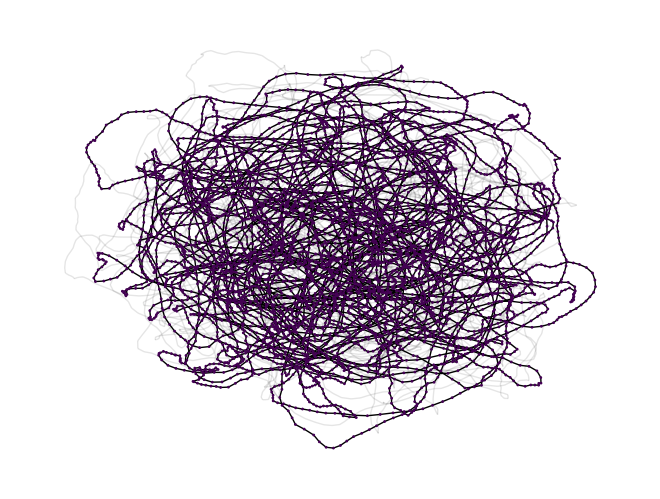

In [125]:
color=[0]*data.shape[0]
for i in range(len(partition)):
    for o in partition[i]:
        color[o]=i
nx.draw(G,node_color=color,node_size=1)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_edges(G, pos, edge_color='black', alpha=0.1)